In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2 
import numpy as np
import pandas as pd
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
import joblib 
import matplotlib.pyplot as plt

In [ ]:

def get_features(path):
    input_size = (512, 512)

    images = os.listdir(path)
    features=[]
    for i in tqdm(images):
        feature=[]

        # gray = cv2.imread(path+img,0)
        # laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

        img = image.load_img(path+i, target_size= input_size)
        # img = image.load_img(path+i)

        gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        feature.extend([laplacian.var(), np.amax(laplacian)])

        features.append(feature)
    return pd.DataFrame(features)

path_undis = '/content/drive/MyDrive/TrainingSet/Undistorted/'
path_art_blur = '/content/drive/MyDrive/TrainingSet/Artificially-Blurred/'
path_nat_blur = '/content/drive/MyDrive/TrainingSet/Naturally-Blurred/'

feature_undis = get_features(path_undis)
print('Undistorted DONE')
feature_art_blur = get_features(path_art_blur)
print('Artificially-Blurred DONE')
feature_nat_blur = get_features(path_nat_blur)
print("Naturally-Blurred DONE")
feature_art_blur.to_csv('/content/drive/MyDrive/art_blur.csv', index=False)
feature_nat_blur.to_csv('/content/drive/MyDrive/nat_blur.csv', index=False)
feature_undis.to_csv('/content/drive/MyDrive/undis.csv', index=False)

In [ ]:
images = pd.DataFrame()

images = pd.DataFrame()
images = images.append(feature_undis)
images = images.append(feature_art_blur)
images = images.append(feature_nat_blur)

x_train = np.array(images)

y_train = np.concatenate((np.zeros((feature_undis.shape[0], )), np.ones((feature_art_blur.shape[0]+feature_nat_blur.shape[0], ))), axis=0)

x_train, y_train = shuffle(x_train, y_train)

In [ ]:
x_test = []
y_test = []

dgbset = pd.read_excel('/content/drive/MyDrive/EvaluationSet/DigitalBlurSet.xlsx')
nbset = pd.read_excel('/content/drive/MyDrive/EvaluationSet/NaturalBlurSet.xlsx')

dgbset['MyDigital Blur'] = dgbset['MyDigital Blur'].apply(lambda x : x.strip())
dgbset = dgbset.rename(index=str, columns={"Unnamed: 1": "Blur Label"})

nbset['Image Name'] = nbset['Image Name'].apply(lambda x : x.strip())

folder_path = '/content/drive/MyDrive/EvaluationSet/DigitalBlurSet/'

input_size = (512, 512)
# load image arrays
for file_name in tqdm(os.listdir(folder_path)):
    if file_name != '.DS_Store':
        
        feature = []

        img = image.load_img(folder_path+file_name, target_size= input_size)
        gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        feature.extend([laplacian.var(), np.amax(laplacian)])

        x_test.append(feature)
        blur = dgbset[dgbset['MyDigital Blur'] == file_name].iloc[0]['Blur Label']
        if blur == 1:
            y_test.append(1)
        else:
            y_test.append(0)
    else:
        print(file_name, 'not a pic')

folder_path = '/content/drive/MyDrive/EvaluationSet/NaturalBlurSet/'

# load image arrays
for file_name in tqdm(os.listdir(folder_path)):
    if file_name != '.DS_Store':
        feature = []

        img = image.load_img(folder_path+file_name, target_size= input_size)
        gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        feature.extend([laplacian.var(), np.amax(laplacian)])

        x_test.append(feature)
        
        blur = nbset[nbset['Image Name'] == file_name.split('.')[0]].iloc[0]['Blur Label']
        if blur == 1:
            y_test.append(1)
        else:
            y_test.append(0)
    else:
        print(file_name, 'not a pic')

test_df = pd.DataFrame(x_test)
test_df['blur_label'] = y_test
test_df.columns = ['laplacian_var', 'laplacian_max', 'blur_label']
test_df.to_csv('/content/drive/MyDrive/test_data.csv', index=False)


In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, classification_report
from sklearn.utils import shuffle

svm_model = svm.SVC(C=50,kernel='rbf')

svm_model.fit(x_train, y_train)


pred =svm_model.predict(x_train)
print('Training Accuracy:',accuracy_score(y_train,pred))

pred =svm_model.predict(np.array(test_df[['laplacian_var', 'laplacian_max']]))
print('Testing Accuracy:',accuracy_score(np.array(test_df['blur_label']),pred))

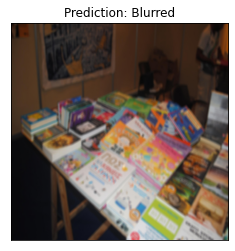

In [ ]:
image_path='/content/drive/MyDrive/EvaluationSet/DigitalBlurSet/DiskR20_8.jpg'
input_size = (512, 512)
img = image.load_img(image_path, target_size = input_size)

gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
img_features = [[laplacian.var(), np.amax(laplacian)]]
plt.imshow(img)
plt.title('Prediction: '+ ('Undistorted' if (svm_model.predict(img_features)[0] == 0) else 'Blurred'))
plt.xticks([])
plt.yticks([])
plt.show()